<a href="https://colab.research.google.com/github/flash-berry/MachineLearning-2025/blob/main/HW_3_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Домашнее задание 3**

ДЗ#3
Эмулировать процесс краудсорс-разметки:
1. Написать мини-инструкцию по оценке релевантности для себя. Оценить по 5 запросам топ-5 выдачи любого поиска и построить распределение оценок.
2. В соответствии с распределением нагенерировать асессорских оценок: часть фродовые, часть просто плохие исполнители, часть очень хорошие
3. Применить Дэвида-Скина для агрегации нагенерированных оценок
4. Продемонстрировать несколько примеров, где Дэвида-Скин отдает предпочтение более качественным исполнителям

Дедлайн: 25 октября

---



**Выполнил студент:** Пышный Артём



---


**ИНСТРУКЦИЯ ДЛЯ АСЕССОРОВ:**

**Цель задания:** оценить качество поисковой выдачи по конкретному запросу и опредеелить релевантность первых 5 результатов поиска.

**Формат задания:**

*   Введите заготовленный поисковый запрос
*   По запросу будет выведен список результатов поиска с заголовком, кратким описанием и URL
*   Ваша задача - для **КАЖДОГО** из первых 5 результатов выставить оценку (релевантность) по шкале от 0 до 2

**Критерии для оценок:**

*   2 - полностью релевантно/точное соответствие: *страница чётко отвечает на запрос, содержит нужную информацию, соответствует теме и намерению пользователя.*
*   1 - частично релевантно/косвенно: *контент страницы относятся к теме, но либо отвечает лишь частично, либо не затрагивает ключевой аспект запроса.*
*   0 - не релевантно: *страница вовсе не относится к запросу, тема и контент не совпадают с запросом.*

**Дополнительные пометки/исключения:**

*   Если результат — страница с ошибкой, “404”, пустая либо “это реклама / спам” - ставьте 0.
*   Если страница перенаправляет на другую тему — 0.
*   Если страница только упоминает ключевые слова, но не раскрывает тему — 1 (если тема соприкасается).
*   Если результат - это страница википедии на EN, хотя уже есть на RU, то ставим 1










In [16]:
!pip install crowd-kit

In [17]:
from crowdkit.aggregation import DawidSkene

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [18]:
def paint_confusion_matrix_workers(y_true, y_preds, titles):
    fig, axes = plt.subplots(2, 3, figsize = (8, 7))

    for ax, y_pred, title in zip(axes.ravel(), y_preds, titles):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
        ax.set_title(title)

    fig.suptitle("Confusion Matrix Workers", fontsize=16)
    plt.tight_layout()
    plt.show()

def probs_dict(n_positions, n_labels):
    probs_prior = np.repeat(1e-3, n_labels)
    probs_posterior = {pos: probs_prior.copy() for pos in range(1, n_positions + 1)}

    for pos in range(1, n_positions + 1):
        pos_data = df_gt[df_gt['position'] == pos]['label']

        label_counts = np.zeros(n_labels)
        for label in range(n_labels):
            label_counts[label] = (pos_data == label).sum()

        probs_posterior[pos] = probs_prior + label_counts

    for pos in range(1, n_positions + 1):
        probs_posterior[pos] = probs_posterior[pos] / probs_posterior[pos].sum()

    return probs_posterior

def generate_assessor_labels(df_gt, probs, n_assessors, fraud_ratio, bad_ratio):
    assessors = [f"A{i + 1}" for i in range(n_assessors)]
    n_fraud = int(n_assessors * fraud_ratio)
    n_bad = int(n_assessors * bad_ratio)
    n_good = n_assessors - n_fraud - n_bad

    types = (
        ["good"] * n_good +
        ["bad"] * n_bad +
        ["fraud"] * n_fraud
    )
    np.random.shuffle(types)

    data = []

    for (task, true_label, position) in df_gt.values:
        for j, a_type in zip(assessors, types):
            if a_type == "good":
                proba = probs[position]
                label = np.random.choice(classes, p = proba)
            elif a_type == "bad":
                label = np.random.choice(classes)
            else:
                label = np.random.choice(classes, p = proba[::-1])

            data.append([task, j, label, a_type])

    df = pd.DataFrame(data, columns=['task', 'worker', 'label', 'type'])

    return df

In [19]:
# 5 queries for evaluation
query_1 = "какого цвета глаза у ким кардашьян?"
query_2 = "из чего была сделана куртка буратино"
query_3 = "когда вышел айфон 15"
query_4 = "как заменить шланг на бойлере не сливая воду"
query_5 = "чем полезен зелёный чай с мелиссой"

num_results = 5

# ground truth
gt = [
    ['https://clck.ru/3PkFx7', 2, 1],
    ['https://clck.ru/3PkFy9', 2, 2],
    ['https://clck.ru/3PkFzN', 1, 3],
    ['https://clck.ru/3PkG2u', 0, 4],
    ['https://clck.ru/3PkGL2', 1, 5],

    ['https://clck.ru/3PkGTG', 2, 1],
    ['https://clck.ru/3PkGej', 2, 2],
    ['https://clck.ru/3PkJeU', 2, 3],
    ['https://clck.ru/3PkJgq', 1, 4],
    ['https://clck.ru/3PkJsf', 0, 5],

    ['https://clck.ru/3PkKSs', 2, 1],
    ['https://clck.ru/3PkKHW', 2, 2],
    ['https://clck.ru/3PkKag', 1, 3],
    ['https://clck.ru/3PkKjU', 0, 4],
    ['https://clck.ru/3PkfLu', 0, 5],

    ['https://clck.ru/3PkfRe', 2, 1],
    ['https://clck.ru/3Pkfpr', 2, 2],
    ['https://clck.ru/3PkfsJ', 2, 3],
    ['https://clck.ru/3PkfuH', 0, 4],
    ['https://clck.ru/3PkfyJ', 1, 5],

    ['https://clck.ru/3Pkg5G', 1, 1],
    ['https://clck.ru/3Pkg6m', 2, 2],
    ['https://clck.ru/3Pkg8g', 2, 3],
    ['https://clck.ru/3PkgAx', 2, 4],
    ['https://clck.ru/3PkgCA', 1, 5]
]

columns_gt = ['task', 'label', 'position']

df_gt = pd.DataFrame(gt, columns=columns_gt)

df_gt.head()

,task,label,position
0,https://clck.ru/3PkFx7,2,1
1,https://clck.ru/3PkFy9,2,2
2,https://clck.ru/3PkFzN,1,3
3,https://clck.ru/3PkG2u,0,4
4,https://clck.ru/3PkGL2,1,5


In [20]:
classes = df_gt["label"].sort_values().unique()
probs = probs_dict(num_results, len(classes))

for position in range(1, num_results + 1):
    proba_pos = probs[position]
    print(f"\n\tПозиция: {position}")
    print(f"Наиболее вероятный label: {proba_pos.argmax()} (p = {proba_pos.max():.4f})")

    for label in range(len(classes)):
        print(f"label {label}: {proba_pos[label]:.4f}")



	Позиция: 1
Наиболее вероятный label: 2 (p = 0.7997)
label 0: 0.0002
label 1: 0.2001
label 2: 0.7997

	Позиция: 2
Наиболее вероятный label: 2 (p = 0.9996)
label 0: 0.0002
label 1: 0.0002
label 2: 0.9996

	Позиция: 3
Наиболее вероятный label: 2 (p = 0.5998)
label 0: 0.0002
label 1: 0.4000
label 2: 0.5998

	Позиция: 4
Наиболее вероятный label: 0 (p = 0.5998)
label 0: 0.5998
label 1: 0.2001
label 2: 0.2001

	Позиция: 5
Наиболее вероятный label: 1 (p = 0.5998)
label 0: 0.4000
label 1: 0.5998
label 2: 0.0002


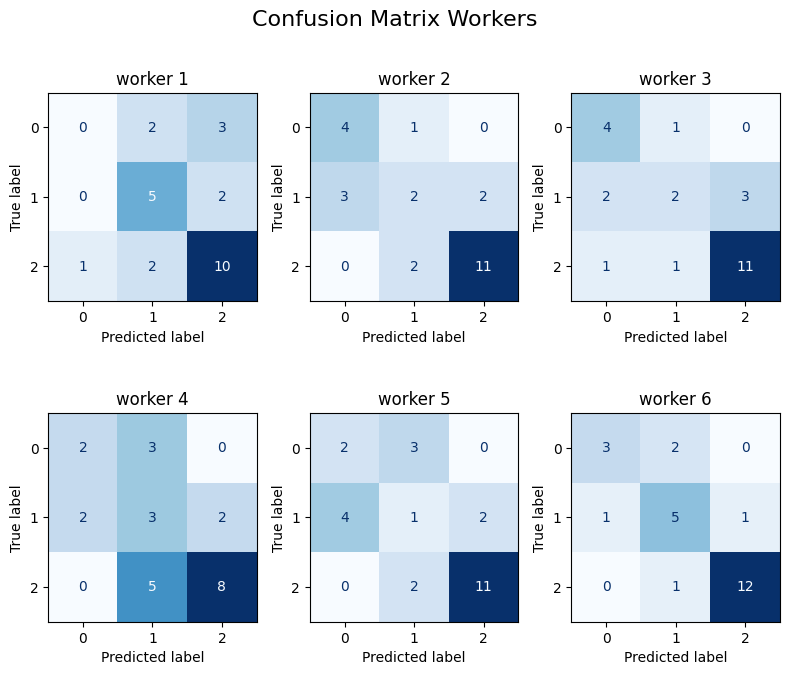

In [21]:
y_true = df_gt['label'].to_numpy()
titles = ['worker 1', 'worker 2', 'worker 3', 'worker 4', 'worker 5', 'worker 6']
y_preds = []

for i in range(len(titles)):
    y_pred = []
    for (task, label, position) in df_gt.values:
        proba = probs[position]
        y_pred.append(np.random.choice(classes, p = proba))
    y_preds.append(y_pred)

paint_confusion_matrix_workers(y_true, y_preds, titles)

У идеального асессора будет наблюдаться диагональная матрица ошибок.

График выше демонстрирует матрицы ошибок шести асессеров, поведение которых описывается распределением оценок по позициям, полученных вручную.

Лучше всего получается определять класс 2.

Класс 0 и 1 получается определять с переменным успехом.

**Вывод:** полученные матрицы и распределения оценок можно посчитать близкими к реальным.

In [22]:
df = generate_assessor_labels(df_gt, probs, n_assessors = 10000, fraud_ratio = 0.1, bad_ratio = 0.2)
print(f"Количество оценок: {len(df)}")

Количество оценок: 250000


In [23]:
df.head()

,task,worker,label,type
0,https://clck.ru/3PkFx7,A1,1,bad
1,https://clck.ru/3PkFx7,A2,2,good
2,https://clck.ru/3PkFx7,A3,2,good
3,https://clck.ru/3PkFx7,A4,2,bad
4,https://clck.ru/3PkFx7,A5,2,good


In [24]:
ds = DawidSkene()
agg_ds = ds.fit_predict(df[['task', 'worker', 'label']])
agg_ds.head()

,agg_label
task,
https://clck.ru/3PkFx7,2
https://clck.ru/3PkFy9,2
https://clck.ru/3PkFzN,2
https://clck.ru/3PkG2u,0
https://clck.ru/3PkGL2,1


In [25]:
y_true = df_gt.set_index('task')['label']

y_pred = agg_ds

y_true = y_true.loc[y_pred.index]

score = f1_score(y_true, y_pred, average = 'macro')
print(f"F1-score (macro): {score:.3f}")

F1-score (macro): 0.652


In [26]:
df_true = y_true.to_frame()
df_pred = y_pred.to_frame()

result = df_true.join(df_pred)
print(f"Верно определено {(result['label'] == result['agg_label']).astype('int').sum()} из {len(df_true)} оценок")

Верно определено 18 из 25 оценок


In [27]:
result = df_true.merge(df_pred, left_index=True, right_index=True)

result['match'] = result['label'] == result['agg_label']

result

,label,agg_label,match
task,,,
https://clck.ru/3PkFx7,2,2,True
https://clck.ru/3PkFy9,2,2,True
https://clck.ru/3PkFzN,1,2,False
https://clck.ru/3PkG2u,0,0,True
https://clck.ru/3PkGL2,1,1,True
https://clck.ru/3PkGTG,2,2,True
https://clck.ru/3PkGej,2,2,True
https://clck.ru/3PkJeU,2,2,True
https://clck.ru/3PkJgq,1,0,False


In [28]:
worker_quality = {}

for worker in ds.errors_.index.get_level_values(0).unique():
    cm = ds.errors_.loc[worker].sort_index()
    quality = cm.values.diagonal().sum() / cm.values.sum()
    worker_quality[worker] = quality

worker_quality = pd.Series(worker_quality).sort_values(ascending=False)
worker_quality

,0
A3716,1.000000e+00
A5342,1.000000e+00
A3688,9.777778e-01
A8723,9.777778e-01
A9591,9.555556e-01
...,...
A8501,6.666667e-02
A651,4.444444e-02
A602,4.444444e-02
A7321,1.555556e-11


Мы оцениваем "надёжность" асессора как среднюю вероятность правильной разметки, которая оценивается как сумма диагональных элементов его матрицы ошибок.

In [29]:
best_workers = worker_quality.head().index.tolist()

df.loc[df['worker'].isin(best_workers), 'type'].value_counts()

,count
type,
good,125


In [30]:
worst_workers = worker_quality.tail().index.tolist()

df.loc[df['worker'].isin(worst_workers), 'type'].value_counts()

,count
type,
fraud,50
bad,50
good,25


**Вывод:** алгоритм Дэвида-Скина смог правильно определить надёжность асессоров и отобрать их, так в хвосте worker_quality находятся в большинстве своём асессоры, относящиеся к типам bad и fraud, а в голове списка только асессоры типа good.